# U-Net based Image Segmentation for locating Radion Frequencey Interference Patches on Sentinel-1 images 

## Initialisations

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# # Initliasations

# Keras deep learning library
import keras
from keras.models import load_model, Model
from keras import backend as K
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Input, concatenate, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import losses

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# Geospatial libraries to handle georeferenced raster and vector data
import fiona
from fiona import collection
import rasterio
import geopandas as gpd
from shapely.geometry import LineString, mapping, shape
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.transform import Affine
from rasterio.warp import reproject, Resampling
from rasterio import windows

In [4]:
# Matplotlib for data plotting
from matplotlib import pyplot as plt

# Scikit learn and scikit image libraries for machine learning and computer vision tools.
from skimage import io, exposure, measure
from sklearn.metrics import jaccard_similarity_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from skimage.feature import greycomatrix, greycoprops
from sklearn.preprocessing import StandardScaler

In [5]:
# Useful python libaries for manipulating data
import os
import pickle
import itertools
import glob
import re
import math

# Pandas to bring dataframe structure
import pandas as pd

# Numpy for numerical processing and arrays
import numpy as np

# Initializse a random number generator to ensure results are reproducible
np.random.seed(7)
# turn warnig off
np.warnings.filterwarnings('ignore')
# print floating points as using fixed point notation i.e. not scientific
np.set_printoptions(suppress=True)
% matplotlib inline

In [7]:
# set some useful paths
# RAW INPUTS
#root = 'i:/DSA/Detect_RFI/'
root = '/Volumes/NewVolume/DSA/Detect_RFI/'
s1_train_dir = os.path.join(root, 'DATA/S1_TRAIN/SPLIT')  # full res input S1 ARD for training
s1_test_dir = os.path.join(root, 'DATA/S1_TEST/SPLIT')  # full res input S1 ARD for testing

# perhaps would be an idea to transform ARD into some generic metric surface like normalised (scale-min max)slope, curvature
# so that model works for images from anywhere
labels_dir = os.path.join(root, 'DATA/LABELS')  # mask polygons

# DERIVED INPUTS
image_chips_dir = os.path.join(root, 'DATA/IMAGE_CHIPS')  # pre-procssed image tiles and mask root folder
model_dir = os.path.join(root, 'MODELS')  # contains the machine learning models
predictions_dir = os.path.join(root, 'PREDICTIONS')

## Load up the masks and store them in a dictionary indexed by the Sentinel-1 tile name

In [31]:
# Create training data polygons from masks shapefile
# open the masks polygons and create an array of geometries for unique tilename
def makeMasks(shapeFileName,labelFieldName):
    LU_LABELS = {}
    with fiona.open(shapeFileName, 'r') as landcovers:
        for feature in landcovers:
            LU_LABEL = feature['properties'][labelFieldName]
            mask = feature["geometry"]
            if LU_LABEL in LU_LABELS:
                oldArray = LU_LABELS[LU_LABEL]
                oldArray.append(mask)
            else:
                LU_LABELS[LU_LABEL] = [mask]
    return LU_LABELS

In [32]:
# read land cover polygon  into geometry arrays that rasterio will use to create masks
labels_shp = os.path.join(labels_dir, 'RFI_Masks_Final.shp')
LU_LABELS = makeMasks(labels_shp,'TILENAME')

## Pre-Processing Input Data i.e. Prepare Image Chips and Mask the non-data/data areas

In [29]:
def maskImage(input_image_name,allPolygons):
    try:
        temp_file_name = input_image_name.replace(".tif","_temp.tif")
        maskDone = False
        with rasterio.open(input_image_name) as src:
            mask_image, mask_transform = rasterio.mask.mask(src,allPolygons,nodata=0)
            mask_meta = src.meta.copy()                   
            # skip this tile if it only has nodata otherwise
            # we are overfeeding nodata
            uniqueLabels = np.unique(mask_image[0,:,:])
            if len(uniqueLabels) < 2 and uniqueLabels[0] ==0:                
                maskDone= input_image_name
            else:
                with rasterio.open(temp_file_name, 'w', **mask_meta) as dest:
                    dest.write(mask_image)
                    maskDone = temp_file_name
        
        if (maskDone == input_image_name):
            os.remove(input_image_name)
        elif (maskDone == temp_file_name):
            os.remove(input_image_name)
            os.rename(temp_file_name,input_image_name)
        return True    
    except Exception as e:
        print(e)
        return maskDone 

In [30]:
# function by cate to create 3D tiles 
def get_tile_images(arr, newshape):
    oldshape = np.array(arr.shape)
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.column_stack([repeats, newshape]).ravel()
    order = np.arange(len(tmpshape))
    order = np.concatenate([order[::2], order[1::2]])
    #pdb.set_trace()
    # newshape must divide oldshape evenly or else ValueError will be raised
    return arr.reshape(tmpshape).transpose(order).reshape(-1, *newshape)

In [26]:
# read the s1 ard image, apply the standard deviation scaling
# it to the ARD
def scaleImage(S1_ImageName, tileYSize, tileXSize):
    with rasterio.open(S1_ImageName) as S1_src:
        newHeight = int(S1_src.height / tileYSize) * tileYSize
        newWidth = int(S1_src.width / tileXSize) * tileXSize
        if (newHeight < tileYSize or newWidth < tileXSize):
            print("newhieght or newwidth are smaller than tile sizes")
            return None,None,None,None
        
        if (newHeight < newWidth):
            newWidth = newHeight
        elif (newWidth < newHeight):
            newHeight = newWidth
    
        S1_image = S1_src.read(window=((0, newWidth), (0, newHeight)))
        
#        if (np.isnan(S1_image.max()) or np.isnan(S1_image.min())):
#            print("nan found")
#            return None,None,None,None
#        if (S1_image.max()<0.0000001 and S1_image.min()<0.0000001):
#            print("near zero found")
#            return None,None,None,None
     
#        print(str(S1_image.max()))
#        print(str(S1_image.min()))
#        print (S1_image.shape)
#        S1_image = exposure.equalize_hist(S1_image)        
        # StandardScaler(copy=True, with_mean=False, with_std=True).fit_transform(S1_image)        
        # show(S1_image)
        
        crs = S1_src.crs
        out_metadata = S1_src.meta.copy()
        out_transform = S1_src.transform   
        
    return S1_image, out_metadata, out_transform, crs

In [27]:
def prepImages(s1_images_dir,image_chips_dir,allPolygons):
    # read the s1 ARD image names that we have and store them in a dictionary
    
    for filename in os.listdir(s1_images_dir):
        if filename.lower().endswith(".tif"):        
            # iterate through the S1 ARD images
            # create image chips
            
            tileName = filename[:4] 
            if tileName in allPolygons:            
                RFI_Masks = allPolygons[tileName]
            else:
                continue
            
            s1_image = os.path.join(s1_images_dir,filename)   
            print("Processing: "+s1_image)
            
            scaled_image, inputMetadata, inputTransform, crs = scaleImage(s1_image,256,256) #1
            if (scaled_image is None):
                continue
            
            ULX = inputTransform.c
            ULY = inputTransform.f
            cellSizeX = inputTransform.a
            cellSizeY = inputTransform.e  
            
            scaled_image_tiled = get_tile_images(scaled_image,(1,256,256)) #2
            
            # write image chips
            numtiles,numbands,rows,cols = scaled_image_tiled.shape
            rowOffset = 0
            blockSize = int(math.sqrt(numtiles))
            for tileIndexAlongY in range(0,blockSize):
                tileULY = ULY + (tileIndexAlongY * cellSizeY * 256)
                for tileIndexAlongX in range(0,blockSize):
                    tileULX = ULX + (tileIndexAlongX * cellSizeX * 256)
                    # print(str(tileULX)+","+str(tileULY))
                    globalTileIndex = tileIndexAlongY + tileIndexAlongX + rowOffset
                    aTileImage = scaled_image_tiled[globalTileIndex,:,:]
                           
                    # aTileImage = np.expand_dims(aTileImage,0)
                    tileMetadata = inputMetadata.copy()
                    tileTransform = Affine(cellSizeX,inputTransform.b,tileULX,inputTransform.d,cellSizeY,tileULY)                

                    # two more bands have been added                
                    tileMetadata.update({'driver': 'GTiff',
                                         'dtype': 'float32',
                                         'count': 1,
                                         'height': 256,
                                         'width': 256,
                                         'crs': crs,
                                         'transform': tileTransform,
                                         'nodata':0})              
                    tileFileName = os.path.basename(s1_image).replace(".tif","_"+str(globalTileIndex).zfill(5)+".tif")
                    tileFullName = os.path.join(image_chips_dir, tileFileName)
                    with rasterio.open(tileFullName, 'w', **tileMetadata) as dest:
                        dest.write(aTileImage)
                
                    #now mask nodata areas in the image
                    maskDone = maskImage(tileFullName,RFI_Masks)
                    if (not maskDone):
                        print("failed")
                    
                rowOffset = rowOffset + (blockSize-1)

In [28]:
def maskImages(images_dir,labels_chips_dir,LU_LABELS):
    for filename in os.listdir(images_dir):
        if filename.endswith(".tif"):
            image_path = os.path.join(images_dir,filename)
            #find the image tile name
            tileName = filename[:4]
            #create a list of output ndarrays
            mask_array = []
            #iterate through the mask vectors
            with rasterio.open(image_path) as src:           
                masks = LU_LABELS[tileName]
                mask_image, mask_transform = rasterio.mask.mask(src,masks,nodata=0)
                mask_meta = src.meta.copy()
                mask_image[mask_image != 0] = 1

                mask_image = mask_image[0].astype('uint8')
                mask_image = np.expand_dims(mask_image, 0)
            
                #save the final mask image
                mask_meta.update({'driver': 'GTiff',
                             'dtype': 'uint8',
                             'count': 1,
                             'height': mask_image.shape[1],
                             'width': mask_image.shape[2],
                             'crs': src.crs,
                             'transform': mask_transform})
                label_file_name = os.path.join(labels_chips_dir,filename.replace(".tif","_labels.tif"))
                with rasterio.open(label_file_name, 'w', **mask_meta) as dest:
                    dest.write(mask_image)

## Convolutional neural network
## The last approach will implement Unet - a popular convolutional neural network for image classifcation

In [ ]:
###Set up the training data

In [ ]:
# preprocess the training RGB and CIR images to resample CIR, extract NIR band, append NIR band to RGB, split into small tiles
train_chips_dir = os.path.join(image_chips_dir, 'TRAIN')
prepImages(s1_train_dir,train_chips_dir, LU_LABELS)

In [9]:
# using rasterio mask function to mask pixels using LU_LABEL in the training images
train_images_dir = os.path.join(image_chips_dir,'TRAIN')
train_labels_chips_dir = os.path.join(train_images_dir,'LABELS')

In [ ]:
maskImages(train_images_dir,train_labels_chips_dir,LU_LABELS)

In [10]:
# set paths to the training data
image_chips = train_images_dir
label_chips = train_labels_chips_dir

In [11]:
# Class to store data and respective labels
# imagese are split into halves..first half used for training, and remaining half into validation
class train_data():
    
    def __init__(self, image, label):
        self.image = []
        self.label = []
        for file in os.listdir(image):
            if file.endswith(".tif"):
                label_file= os.path.join(label,file.replace(".tif","_labels.tif"))
                imgArray = io.imread(image+"/"+file,0)
                #print(imgArray.shape)
                imgArray = np.expand_dims(imgArray,2)
                #print(imgArray.shape)
                self.image.append(imgArray)
                lblArray = io.imread(label_file,0)
                lblArray = np.expand_dims(lblArray,2)
                self.label.append(lblArray)
    
    # training half
    def get_image(self):
        return np.array(self.image[:int(len(self.image)/2)])

    def get_label(self):
        return np.array(self.label[:int(len(self.image)/2)])
    
    # validation half
    def get_validation_image(self):
        return np.array(self.image[int(len(self.image)/2):])
    
    def get_validation_label(self):
        return np.array(self.label[int(len(self.image)/2):])
        
    def set_image(self, new_images):
        self.image = new_image
    
    def set_label(self,new_label):
        self.label = new_label

In [12]:
# run the training data creation
train_set = train_data(image_chips, label_chips)

(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)
(256, 256)
(256, 256, 1)


In [13]:
# access the training set
train_images = train_set.get_image()
train_label = train_set.get_label()
# access the validation set
validation_image = train_set.get_validation_image()
validation_label = train_set.get_validation_label()
# one hot encode the labels
train_label_encoded = to_categorical(train_label, num_classes=2)
validation_label_encoded = to_categorical(validation_label, num_classes=2)

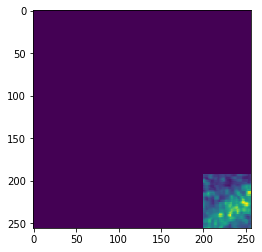

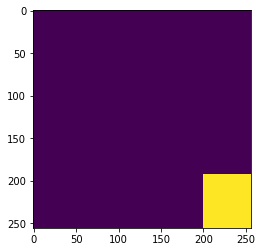

In [20]:
show(train_images[44,:,:,:])
show(train_label[44,:,:,:])

In [21]:
# check that Keras expects the bands to be passed last - i.e. the data is shaped (256, 256, 12)
keras.backend.image_data_format()

'channels_last'

In [49]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [50]:
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
def unet_zhixuhao(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(2, (1, 1), activation = 'softmax')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [53]:
# define the Unet architecture
def unet_cate(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # use softmax in order to only output one class per pixel (unlike sigmoid which can have multiclass)
    conv10 = Conv2D(2, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
        
    #model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(lr=1e-9), loss='binary_crossentropy', metrics=['accuracy'])
    # see if a different loss and metrics can improve e.g. sorenson-dice
    # model.compile(optimizer=Adam(lr=1e-9), loss=dice_coef_loss, metrics=[dice_coef])
    
    model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)
    
    return model

In [54]:
# train the model
model = unet_cate()
model.fit(train_images, train_label_encoded, validation_data=(validation_image, validation_label_encoded), epochs=100,
          batch_size=8, shuffle=True)
# save the model and weights
model.save(os.path.join(model_dir, '20181014_Unet_100epoch_RFI_dice.h5'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 32) 320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_39[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_41 

45/45 [==============================] - 71s 2s/step - loss: 0.6930 - acc: 0.9177 - val_loss: nan - val_acc: 0.9102
Epoch 72/100
45/45 [==============================] - 71s 2s/step - loss: 0.6930 - acc: 0.9178 - val_loss: nan - val_acc: 0.9104
Epoch 73/100
45/45 [==============================] - 71s 2s/step - loss: 0.6930 - acc: 0.9179 - val_loss: nan - val_acc: 0.9105
Epoch 74/100
45/45 [==============================] - 71s 2s/step - loss: 0.6930 - acc: 0.9180 - val_loss: nan - val_acc: 0.9107
Epoch 75/100
45/45 [==============================] - 71s 2s/step - loss: 0.6930 - acc: 0.9182 - val_loss: nan - val_acc: 0.9108
Epoch 76/100
45/45 [==============================] - 71s 2s/step - loss: 0.6930 - acc: 0.9183 - val_loss: nan - val_acc: 0.9109
Epoch 77/100
45/45 [==============================] - 71s 2s/step - loss: 0.6930 - acc: 0.9184 - val_loss: nan - val_acc: 0.9111
Epoch 78/100
45/45 [==============================] - 71s 2s/step - loss: 0.6930 - acc: 0.9185 - val_loss: nan

In [ ]:
#model = load_model(os.path.join(model_dir, '20180905_Unet_10epoch.h5'))

# lower the learning rate
#lr = 0.0001
#K.set_value(model.optimizer.lr, lr)

#model.fit(train_images, train_label_encoded, validation_data=(validation_image, validation_label_encoded), epochs=10,
#          batch_size=10, shuffle=True)
#model.save(os.path.join(model_dir, '20180905_Unet_20epoch.h5'))

In [ ]:
#model = load_model(os.path.join(model_dir, '20180905_Unet_20epoch.h5'))

# try increasing the learning rate as little improvement was seen in previous epochs
#lr = 0.001
#K.set_value(model.optimizer.lr, lr)

#model.fit(train_images, train_label_encoded, validation_data=(validation_image, validation_label_encoded), epochs=10,
#          batch_size=8, shuffle=True)
#model.save(os.path.join(model_dir, '20180905_Unet_30epoch.h5'))

## Test the accuracy of the predictions using known test cases

In [33]:
# preprocess the test RGB and CIR images to resample CIR, extract NIR band, append NIR band to RGB, split into small tiles
test_chips_dir = os.path.join(image_chips_dir, 'TEST')
prepImages(s1_test_dir,test_chips_dir,LU_LABELS)

Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_8_9.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_8_10.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_8_11.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_8_12.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_8_13.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_8_14.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_8_15.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_8_16.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_8_17.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_8_18.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_8_19.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_8_20.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1

Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_13_3.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_13_4.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_13_5.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_13_6.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_13_7.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_13_8.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_13_9.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_13_10.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_13_11.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_13_12.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_13_13.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_13_14.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/D

Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_0_5.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_0_6.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_0_7.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_0_8.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_0_9.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_0_10.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_0_11.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_0_12.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_0_13.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_0_14.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_0_15.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_0_16.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TES

Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_5_1.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_5_2.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_5_3.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_5_4.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_5_5.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_5_6.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_5_7.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_5_8.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_5_9.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_5_10.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_5_11.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_5_12.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SP

Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_9_18.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_9_19.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_9_20.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_9_21.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_10_0.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_10_1.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_10_2.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_10_3.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_10_4.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_10_5.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_10_6.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_10_7.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S

Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_14_12.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_14_13.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_14_14.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_14_15.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_14_16.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_14_17.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_14_18.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_14_19.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_14_20.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_14_21.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_15_0.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/A48B_15_1.tif
Processing: /Volumes/NewVolume/DSA/Detect_

Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_2_8.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_2_9.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_2_10.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_2_11.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_2_12.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_2_13.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_2_14.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_2_15.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_2_16.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_2_17.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_2_18.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_2_19.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_

Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_7_8.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_7_9.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_7_10.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_7_11.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_7_12.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_7_13.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_7_14.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_7_15.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_7_16.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_7_17.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_7_18.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_7_19.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_

Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_12_7.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_12_8.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_12_9.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_12_10.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_12_11.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_12_12.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_12_13.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_12_14.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_12_15.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_12_16.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_12_17.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_12_18.tif
Processing: /Volumes/NewVolume/DSA/Detect_R

newhieght or newwidth are smaller than tile sizes
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_16_19.tif
newhieght or newwidth are smaller than tile sizes
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/F7B7_16_20.tif
newhieght or newwidth are smaller than tile sizes
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_0_0.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_0_1.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_0_2.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_0_3.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_0_4.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_0_5.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_0_6.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_0_7.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E

Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_4_13.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_4_14.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_4_15.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_4_16.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_4_17.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_4_18.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_4_19.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_4_20.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_4_21.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_5_0.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_5_1.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_5_2.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_T

Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_9_8.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_9_9.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_9_10.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_9_11.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_9_12.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_9_13.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_9_14.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_9_15.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_9_16.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_9_17.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_9_18.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_9_19.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_

Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_14_2.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_14_3.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_14_4.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_14_5.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_14_6.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_14_7.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_14_8.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_14_9.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_14_10.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_14_11.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_14_12.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/E9CD_14_13.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DA

Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_1_18.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_1_19.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_1_20.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_1_21.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_2_0.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_2_1.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_2_2.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_2_3.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_2_4.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_2_5.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_2_6.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_2_7.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/S

Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_6_13.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_6_14.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_6_15.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_6_16.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_6_17.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_6_18.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_6_19.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_6_20.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_6_21.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_7_0.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_7_1.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_TEST/SPLIT/3F53_7_2.tif
Processing: /Volumes/NewVolume/DSA/Detect_RFI/DATA/S1_T

In [34]:
test_images_dir = os.path.join(image_chips_dir,'TEST')
test_labels_chips_dir = os.path.join(test_images_dir,'LABELS')

In [35]:
# using rasterio mask function to mask pixels using LU_LABEL in the test images
maskImages(test_images_dir,test_labels_chips_dir,LU_LABELS)

In [55]:
# read in the trained model
unet_model = load_model(os.path.join(model_dir, '20181014_Unet_100epoch_RFI_dice.h5'))

In [36]:
# load test data
test_image_chips = test_images_dir 
test_label_chips = test_labels_chips_dir 

class test_data():
    
    def __init__(self, image, label):
        self.image = []
        self.label = []
        self.filename = [] # store the filename because we can use it later to recreate the predicted image for it
        
        for file in os.listdir(image):
            
            if file.endswith(".tif"):
                label_file= os.path.join(label,file.replace(".tif","_labels.tif"))
                imgArray = io.imread(image+"/"+file,0)
                imgArray = np.expand_dims(imgArray, 2) # this is done to meet keras channel order needs
                self.image.append(imgArray)
                lblArray = io.imread(label_file,0)
                lblArray = np.expand_dims(lblArray,2)
                self.label.append(lblArray)
                self.filename.append(file)
               
    def get_image(self):
        return np.array(self.image[:int(len(self.image))])

    def get_label(self):
        return np.array(self.label[:int(len(self.image))])
        
    def set_image(self, new_images):
        self.image = new_image
    
    def set_label(self,new_label):
        self.label = new_label

In [39]:
# create the test set
test_set = test_data(test_image_chips, test_label_chips)
# access the test images and labels
test_images = test_set.get_image()
test_label = test_set.get_label()
# one-hot-encode the labels
test_label_encoded = to_categorical(test_label, num_classes=2)

In [56]:
# make predictions on the test set using the trained model
test_predict = unet_model.predict(test_images, verbose=1)

113/113 [==============================] - 46s 404ms/step


In [57]:
# decode the predictions
test_predict_decoded = np.argmax(test_predict, axis=3)

In [42]:
# to show the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [45]:
 
# to calculate all metrics
def accuracy_statistics(true_class, predicted_class):
   
    # classification report
    #target_names = ["Class {}".format(i) for i in range(3)]
    print('Classification Report')
    print(classification_report(true_class, predicted_class))
   
    # jaccard
    print('Jaccard Score:')
    print(jaccard_similarity_score(true_class, predicted_class))
   
    # confusion matrix
    # plt.figure()
    print ('Confusion Matrix')
    #print(confusion_matrix(true_class, predicted_class))
    cnf_matrix = confusion_matrix(true_class, predicted_class)

    plot_confusion_matrix(cnf_matrix, classes=['NoData', 'RFI Area'],
                          title='Confusion Matrix')
    plot_confusion_matrix(cnf_matrix, classes=['NoData', 'RFI Area'], normalize=True,
                          title='Normalized Confusion Matrix')

Classification Report
             precision    recall  f1-score   support

          0       0.86      0.95      0.90   3858303
          1       0.94      0.82      0.88   3547265

avg / total       0.90      0.89      0.89   7405568

Jaccard Score:
0.8902524424865182
Confusion Matrix
Confusion matrix, without normalization


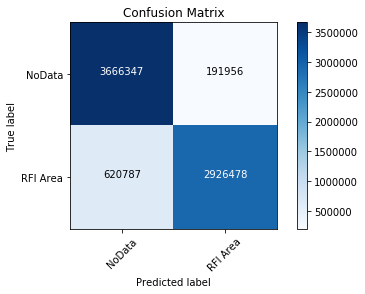

Normalized confusion matrix


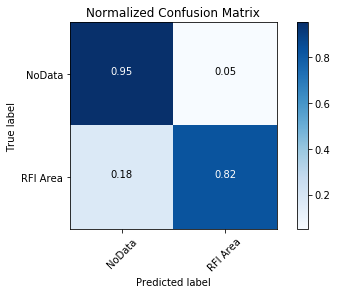

In [58]:
# generate accuracy statistics
accuracy_statistics(test_label.ravel(), test_predict_decoded.ravel())

In [48]:
# iterate through the test_images, find the related predicted arrays, find the geotransformation of the test_image it came from
# and the save the predicted array as an image using the geotransform
for tileNum in range(len(test_predict_decoded)):
    imgFileName = test_set.filename[tileNum]
    imageFullName = os.path.join(test_image_chips,imgFileName)
    with rasterio.open(imageFullName) as src:
        out_transform = src.transform
        out_meta = {'driver': 'GTiff',
                    'dtype': 'uint8',
                    'count': 1,
                    'height': 256,
                    'width': 256,
                    'crs': src.crs,
                    'transform': out_transform,
                    'nodata':0}
        predictionFileName = os.path.join(predictions_dir, 'UNET',imgFileName.replace(".tif","_prediction.tif"))
        with rasterio.open(predictionFileName, 'w', **out_meta) as dest:
                    im_prediction = test_predict_decoded[tileNum,:,:]
                    im_prediction = np.expand_dims(im_prediction, 0)
                    im_prediction = im_prediction.astype('uint8')
                    dest.write(im_prediction) 